In [1]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np 
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from string import punctuation
nltk.download("stopwords")
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from pymystem3 import Mystem
from datetime import datetime, timedelta
import functools
import operator
import chart_studio.plotly as py
#import plotly.graph_obs as go
from plotly.offline import iplot
import cufflinks as cf
from nltk import ngrams
import plotly.express as px
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
noise = stopwords.words('russian') + list(punctuation)
upnoise = [letter.upper() for letter in noise]
sum_noise = noise+upnoise+['.','»','«', 'Коллега', "коллега", "это", "который", "свой"]

[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("fb.csv", index_col=0)

In [3]:
df

,time,post,number_comments,comment
0,2020-10-01,Коллеги! Размещаю видео с судебным юристом Тат...,9,"[', спасибо, из за очепятки я прочитала аккуль..."
1,2020-10-05,"Коллеги, клиент не спросив оплатил проверку 19...",2,['документы и регистрировать через регистратор...
2,2020-10-05,Приплыло. Сделка цепь. Нижний просит заложить ...,5,['ИтакаСоглашайтесь на их оценщика . Ссылку пр...
3,2020-10-05,"Коллеги, добрый день! Нужна помощь)) нужны фот...",52,"['ты уже и в Америке работаешь, Наташ?', 'Лурь..."
4,2020-10-05,"Время сейчас такое, что иногда приходят два по...",10,"['распашонка?', 'Лукашевская, да', 'банк?', 'Б..."
...,...,...,...,...
107,2020-10-01,"Уважаемые коллеги, поделитесь пожалуйста опыто...",0,[]
108,2020-10-01,"Уважаемы, коллеги, кто как поступил бы в этой ...",0,[]
109,2019-10-31,"Пост благодарности Серебряков Андрей, или «не...",0,[]
110,2020-10-01,"А нет ли среди вас волшебников, которые смогли...",0,[]


In [4]:
def tokeniz(df):
        ##########TIME#######################
    for i in range(len(df)):
        df['time'][i] = datetime.strptime(df["time"][i], '%Y-%m-%d')
    #########COMMENTS#####################
    for i in range(len(df)):
        df["comment"][i] = list(df["comment"][i][2:-2].replace("'", '').split(','))
    tw = TweetTokenizer()
    det = TreebankWordDetokenizer()
    for i in (range(len(df))):
        for j in range(len(df["comment"][i])):
            tokenized_example = (tw.tokenize(df["comment"][i][j]))
            filtered_example = [word for word in tokenized_example if not word in sum_noise]
            df["comment"][i][j] = det.detokenize(filtered_example)
    mystem_analyzer = Mystem(entire_input=False)
    for i in (range(len(df))):
        df["comment"][i] = [mystem_analyzer.lemmatize(w) for w in df["comment"][i]]
        df["comment"][i] = list(filter(None, df["comment"][i]))


    ##########POSTS##############
    for i in (range(len(df))):
            tokenized_example = (tw.tokenize(df["post"][i]))
            filtered_example = [word for word in tokenized_example if not word in sum_noise]
            df["post"][i] = det.detokenize(filtered_example)
    for i in (range(len(df))):
        a = []
        a.append(df['post'][i])
        df["post"][i] = a
    for i in (range(len(df))):
        df["post"][i] = [mystem_analyzer.lemmatize(w) for w in df["post"][i]][0]
tokeniz(df)
df

,time,post,number_comments,comment
0,2020-10-01 00:00:00,"[коллега, размещать, видео, судебный, юрист, т...",9,"[[спасибо], [очепятка, прочитывать, аккультный..."
1,2020-10-05 00:00:00,"[коллега, клиент, спрашивать, оплачивать, пров...",2,"[[документ, регистрировать, регистратор], [ден..."
2,2020-10-05 00:00:00,"[приплывать, сделка, цепь, нижний, просить, за...",5,"[[итакасоглашаться, оценщик, ссылка, присылать..."
3,2020-10-05 00:00:00,"[коллега, добрый, день, нужный, помощь, нужный...",52,"[[америка, работать], [наташа], [лурье], [вспо..."
4,2020-10-05 00:00:00,"[время, такой, приходить, покупатель, квартира...",10,"[[распашонка], [лукашевский], [банк], [быков],..."
...,...,...,...,...
107,2020-10-01 00:00:00,"[уважаемый, коллега, поделиться, пожалуйста, о...",0,[]
108,2020-10-01 00:00:00,"[уважаемый, коллега, поступать, ситуация, стоя...",0,[]
109,2019-10-31 00:00:00,"[пост, благодарность, серебряков, андрей, имет...",0,[]
110,2020-10-01 00:00:00,"[среди, волшебник, который, смочь, срочно, пре...",0,[]


In [5]:
def avg_datetime(series):
    return (series - series.min()).mean() + series.min()


In [6]:
class TextAnalyzer:
    def __init__(self, df):
        self.df = deepcopy(df)
    def date_slice(self, start_date = None, end_date = None):
        if start_date == None and end_date == None:
                self.df1 = deepcopy(self.df)
        
        if (type(start_date) == list or type(end_date) == list):
            if (not start_date == None ) and (not end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = self.df[self.df['time']<end_date]
                self.df1 = self.df1[self.df1['time']>start_date]
            elif (not start_date == None ) and (end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                self.df1 = self.df[self.df['time']>start_date]
            elif (start_date == None ) and (not end_date==None):
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = self.df[self.df['time']<end_date]
        elif (type(start_date) == datetime  and type(end_date) == datetime):
            self.df1 = self.df[self.df['time']<end_date]
            self.df1 = self.df1[self.df1['time']>=start_date]
    def frequency(self,  numb, text_type, start_date = None, end_date = None, ngram = 1, draw=True, output=True):
        #start&end date = [d, m ,y]
        if ngram>1:
            draw = False
        self.numb = numb
        self.wordcount = {}
        self.text_type = text_type
        self.draw = draw
        #self.start_date = start_date
        #self.end_date = end_date
       
        self.date_slice(start_date, end_date)
        
        if self.text_type == 'comment':
            
            self.df1.index = np.arange(len(self.df1))
            if ngram>1:
                for i in range(len(self.df1)):
                    for j in range(len(self.df1['comment'][i])):
                        self.df1['comment'][i][j] = list(ngrams(self.df1['comment'][i][j],ngram))
            for i in range(len(self.df1)):
                for j in range(len(self.df1['comment'][i])):
                    for word in (self.df1['comment'][i][j]):
                        if ngram==1:
                            word = word.replace(".","")
                            word = word.replace(",","")
                            word = word.replace(":","")
                            word = word.replace("\"","")
                            word = word.replace("!","")
                            word = word.replace("â€œ","")
                            word = word.replace("â€˜","")
                            word = word.replace("*","")
                            word = word.replace(" ","")
                        if word not in sum_noise:
                            if word not in self.wordcount.keys():
                                self.wordcount[word] = 1
                            else:
                                self.wordcount[word] += 1
        if self.text_type == 'post':
            self.df1.index = np.arange(len(self.df1))
            if ngram>1:
                for i in range(len(self.df1)):
                    self.df1['post'][i] = list(ngrams(self.df1['post'][i],ngram))
            for i in range(len(self.df1)):   
                for word in self.df1['post'][i]:
                    if ngram==1:
                        word = word.replace(".","")
                        word = word.replace(",","")
                        word = word.replace(":","")
                        word = word.replace("\"","")
                        word = word.replace("!","")
                        word = word.replace("â€œ","")
                        word = word.replace("â€˜","")
                        word = word.replace("*","")
                        word = word.replace(" ","")
                    if word not in sum_noise:
                        if word not in self.wordcount.keys():
                            self.wordcount[word] = 1
                        else:
                            self.wordcount[word] += 1
        self.word_counter = collections.Counter(self.wordcount)
        if output:
            print("The {} most common words are as follows\n".format(self.numb))
            for word, count in self.word_counter.most_common(self.numb):
                print(word, ": ", count)
        if self.draw:
            lst = self.word_counter.most_common(self.numb)
            df_cnt = pd.DataFrame(lst, columns = ['Word', 'Count'])
            df_cnt.plot.bar(x='Word',y='Count')
        if ngram>1:
            global df 
            df = pd.read_csv("fb.csv", index_col=0)
            tokeniz(df)
            self.df = df
    def date_top(self, text_type, start_date_1 = None, end_date_1 = None, draw = False):
        if start_date_1 == None and end_date_1 == None:
            self.df1 = self.df
        elif (not start_date_1 == None ) and (not end_date_1==None):
            start_date_1 = datetime(start_date_1[2], start_date_1[1], start_date_1[0], 0, 0)
            end_date_1 = datetime(end_date_1[2], end_date_1[1], end_date_1[0], 0, 0)
            self.df1 = self.df[self.df['time']<end_date_1]
            self.df1 = self.df1[self.df1['time']>=start_date_1]
        elif (not start_date_1 == None ) and (end_date_1==None):
            start_date_1 = datetime(start_date_1[2], start_date_1[1], start_date_1[0], 0, 0)
            self.df1 = self.df[self.df['time']>=start_date_1]
        elif (start_date_1 == None ) and (not end_date_1==None):
            end_date_1 = datetime(end_date_1[2], end_date_1[1], end_date_1[0], 0, 0)
            self.df1 = self.df[self.df['time']<end_date_1]
            
        self.dates = np.sort(self.df1['time'].unique())
        self.top_words = []
        for i in range(len(self.dates)):
            self.frequency(1, text_type, start_date = self.dates[i], end_date = self.dates[i]+timedelta(days=1), draw = draw, output=False)
            #self.top_words.append(self.word_counter.most_common(1)[0][0])
            if not len(self.word_counter.most_common(1)) == 0:
                print(self.word_counter.most_common(1)[0][0], self.dates[i].date(), '\n')
            else:
                print('no comments', self.dates[i].date(), '\n')
    def word_in_time(self, word):
        self.word = word
        self.dates = np.sort(self.df['time'].unique())
        self.wrd_cnt = []
        for i in range(len(self.dates)):
            self.count = 0
            self.dfwrd = df[df['time'] == self.dates[i]]
            self.dfwrd.index = np.arange(len(self.dfwrd))
            for j in range(len(self.dfwrd)):
                for word1 in self.dfwrd['post'][j]:
                    if word1 == self.word:
                        self.count +=1
                for comm in self.dfwrd['comment'][j]:
                    for word2 in comm:
                        if word2 == self.word:
                            self.count +=1
            self.wrd_cnt.append(self.count)
        self.plots = pd.DataFrame(self.wrd_cnt)
        self.plots['date'] = self.dates
        f = plt.figure(figsize=(19, 15))
        fig = px.line(self.plots, x='date', y = 0)
        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        )
        fig.show()
        
    def date_unique(self, nmb, start_date = None, end_date = None):
        self.date_slice(start_date, end_date)
        self.df1_nd = deepcopy(self.df.iloc[np.delete(np.arange(len(self.df)), self.df1.index),:])
        self.df1.index = np.arange(len(self.df1))
        self.nmb = nmb
        self.d = ''
        for i in range(len(self.df1)):
            self.d += ' ' + det.detokenize(self.df1['post'][i])
        for i in range(len(self.df1)):
            for j in range(len(self.df1['comment'][i])):
                self.d += ' ' + det.detokenize(self.df1['comment'][i][j])
        self.df1_nd.index = np.arange(len(self.df1_nd))
        self.nd = ''
        for i in range(len(self.df1_nd)):
            self.nd += ' ' + det.detokenize(self.df1_nd['post'][i])
        for i in range(len(self.df1_nd)):
            for j in range(len(self.df1_nd['comment'][i])):
                self.nd += ' ' + det.detokenize(self.df1_nd['comment'][i][j])
        self.ls_dt = [self.d, self.nd]
        vectorizer = TfidfVectorizer()
        self.X = vectorizer.fit_transform(self.ls_dt)
        self.tt = pd.DataFrame(self.X.toarray(), columns=vectorizer.get_feature_names())
        self.dick = dict(zip(self.tt.columns, self.tt.loc[0]))
        self.utp = sorted(self.dick, key=self.dick.get, reverse=True)
        for i in range(10):
            print('{}:'.format(i+1)+' '+self.utp[i])

In [139]:
test = TextAnalyzer(df)

The 10 most common words are as follows

квартира :  268
сделка :  164
право :  149
ребенок :  142
клиент :  124
год :  121
мочь :  114
покупатель :  113
человек :  107
продавец :  92


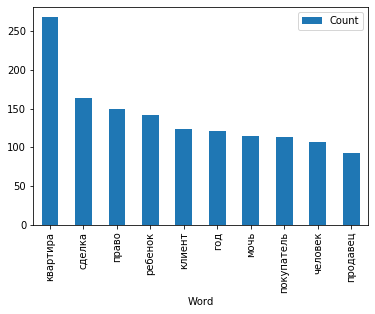

In [140]:
test.frequency(10, 'comment', start_date=[28,9,2020])

In [142]:
test.date_unique(5, start_date=[3,10,2020])

1: такой
2: квартира
3: сделка
4: клиент
5: вы
6: покупатель
7: мочь
8: другой
9: собственник
10: человек


In [110]:
test.date_top('post')
#next to 1 word

андрей 2019-10-31 

хороший 2020-01-10 

уважаемый 2020-08-25 

сегодня 2020-08-31 

задаток 2020-09-18 

⠀ 2020-09-21 

завещание 2020-09-23 

добрый 2020-09-24 

бороться 2020-09-26 

продавать 2020-09-28 

друг 2020-09-29 

сказать 2020-09-30 

квартира 2020-10-01 

сделка 2020-10-02 

шуба 2020-10-03 

дом 2020-10-04 

квартира 2020-10-05 



In [28]:
test.dates[1].date()

datetime.date(2020, 1, 10)

In [117]:
test.word_in_time('дкп')

<Figure size 1368x1080 with 0 Axes>

In [124]:
list(ngrams(df['comment'][1][0],2))

[('документ', 'регистрировать'), ('регистрировать', 'регистратор')]

In [39]:
df['post'][1][1]
wordcount = {}

In [40]:
for i in range(len(df)):   
        for word in df['post'][i]:
            '''word = word.replace(".","")
            word = word.replace(",","")
            word = word.replace(":","")
            word = word.replace("\"","")
            word = word.replace("!","")
            word = word.replace("â€œ","")
            word = word.replace("â€˜","")
            word = word.replace("*","")
            word = word.replace(" ","")'''
            if word not in sum_noise:
                if word not in wordcount.keys():
                    wordcount[word] = 1
                else:
                    wordcount[word] += 1

In [43]:
wordcount

{(('коллега', 'размещать'), ('размещать', 'видео')): 1,
 (('размещать', 'видео'), ('видео', 'судебный')): 1,
 (('видео', 'судебный'), ('судебный', 'юрист')): 1,
 (('судебный', 'юрист'), ('юрист', 'татьяна')): 1,
 (('юрист', 'татьяна'), ('татьяна', 'пак')): 1,
 (('татьяна', 'пак'), ('пак', 'мы')): 1,
 (('пак', 'мы'), ('мы', 'поговорить')): 1,
 (('мы', 'поговорить'), ('поговорить', 'процедура')): 1,
 (('поговорить', 'процедура'), ('процедура', 'банкротство')): 1,
 (('процедура', 'банкротство'), ('банкротство', 'физический')): 1,
 (('банкротство', 'физический'), ('физический', 'лицо')): 1,
 (('физический', 'лицо'), ('лицо', 'посмотреть')): 1,
 (('лицо', 'посмотреть'), ('посмотреть', 'именно')): 1,
 (('посмотреть', 'именно'), ('именно', 'глаз')): 1,
 (('именно', 'глаз'), ('глаз', 'этот')): 1,
 (('глаз', 'этот'), ('этот', 'процедура')): 1,
 (('этот', 'процедура'), ('процедура', 'заниматься')): 1,
 (('процедура', 'заниматься'), ('заниматься', 'надеяться')): 1,
 (('заниматься', 'надеяться'), 

In [48]:
collections.Counter(wordcount).most_common(10)

[((('коллега', 'добрый'), ('добрый', 'день')), 4),
 ((('подсказывать', 'пожалуйста'), ('пожалуйста', 'нужно')), 2),
 ((('давно', 'проходить'), ('проходить', 'тот')), 2),
 ((('проходить', 'тот'), ('тот', 'время')), 2),
 ((('тот', 'время'), ('время', 'человек')), 2),
 ((('время', 'человек'), ('человек', 'обманывать')), 2),
 ((('человек', 'обманывать'), ('обманывать', 'оставаться')), 2),
 ((('обманывать', 'оставаться'), ('оставаться', 'жилье')), 2),
 ((('оставаться', 'жилье'), ('жилье', 'да')), 2),
 ((('жилье', 'да'), ('да', 'нешто')), 2)]

In [40]:
for i in range(len(df1)):   
                for word in df1['post'][i]:
                    word = word.replace(".","")
                    word = word.replace(",","")
                    word = word.replace(":","")
                    word = word.replace("\"","")
                    word = word.replace("!","")
                    word = word.replace("â€œ","")
                    word = word.replace("â€˜","")
                    word = word.replace("*","")
                    if word not in sum_noise:
                        if word not in wordcount:
                            wordcount[word] = 1
                        else:
                            wordcount[word] += 1
print("The {} most common words are as follows\n".format(numb))
self.word_counter = collections.Counter(wordcount)
for word, count in self.word_counter.most_common(numb):
    print(word, ": ", count)

NameError: name 'wordcount' is not defined

In [99]:
a[0][0]

'квартира'

In [90]:
df = pd.read_csv('fb.csv', index_col=0)

In [92]:
tokeniz(df)

In [94]:
df1 = deepcopy(df)

In [87]:
a = [7, 3, 4]
b = a
c = a[:]
b[0] = 10
print ('a: ', a, id(a))
print ('b: ', b, id(b))
print ('c: ', c, id(c))


a:  [10, 3, 4] 139771536083536
b:  [10, 3, 4] 139771536083536
c:  [7, 3, 4] 139771536077360


In [109]:
id(test.df), id(df)

(139771532743248, 139771540288400)

In [108]:
test.df['post'][1]=['xuy']

In [111]:
df

,time,post,number_comments,comment
0,2020-10-01 00:00:00,"[коллега, размещать, видео, судебный, юрист, т...",9,"[[спасибо], [очепятка, прочитывать, аккультный..."
1,2020-10-05 00:00:00,"[коллега, клиент, спрашивать, оплачивать, пров...",2,"[[документ, регистрировать, регистратор], [ден..."
2,2020-10-05 00:00:00,"[приплывать, сделка, цепь, нижний, просить, за...",5,"[[итакасоглашаться, оценщик, ссылка, присылать..."
3,2020-10-05 00:00:00,"[коллега, добрый, день, нужный, помощь, нужный...",52,"[[америка, работать], [наташа], [лурье], [вспо..."
4,2020-10-05 00:00:00,"[время, такой, приходить, покупатель, квартира...",10,"[[распашонка], [лукашевский], [банк], [быков],..."
...,...,...,...,...
107,2020-10-01 00:00:00,"[уважаемый, коллега, поделиться, пожалуйста, о...",0,[]
108,2020-10-01 00:00:00,"[уважаемый, коллега, поступать, ситуация, стоя...",0,[]
109,2019-10-31 00:00:00,"[пост, благодарность, серебряков, андрей, имет...",0,[]
110,2020-10-01 00:00:00,"[среди, волшебник, который, смочь, срочно, пре...",0,[]


In [113]:
test.df1 = test.df

In [114]:
for i in range(len(test.df1)):
    for j in range(len(test.df1['comment'][i])):
        test.df1['comment'][i][j] = list(ngrams(test.df1['comment'][i][j],2))

In [120]:
id(test.df), id(test.df1), id(df)

(139771532743248, 139771532743248, 139771540288400)

In [13]:
det = TreebankWordDetokenizer()
a = [det.detokenize(df['post'][1]), det.detokenize(df['post'][2])]

In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(a)

In [40]:
tt = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [38]:
np.sort(pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()))[::-1][:2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.37796447, 0.37796447,
        0.37796447, 0.37796447, 0.37796447, 0.37796447, 0.37796447],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16439899, 0.16439899, 0.16439899,
        0.16439899, 0.16439899, 0.16439899, 0.16439899, 0.16439899,
        0.16439899, 0.16439899, 0.16439899, 0.16439899, 0.16439899,
        0.16439899, 0.16439899, 0.16439899, 0.16439899, 0.16439899,
        0.16439899, 0.16439899, 0.32879797, 0.32879797, 0.49319696]])

In [41]:
tt

,висеть,витрина,все,делать,доллар,еще,закладывать,замечание,кабинет,клиент,...,приходиться,проверка,пропадать,просить,сбера,сделка,спрашивать,теперь,цепь,якобы
0,0.328798,0.164399,0.164399,0.164399,0.000000,0.164399,0.000000,0.164399,0.164399,0.164399,...,0.164399,0.164399,0.164399,0.000000,0.164399,0.000000,0.164399,0.164399,0.000000,0.164399
1,0.000000,0.000000,0.000000,0.000000,0.377964,0.000000,0.377964,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.377964,0.000000,0.377964,0.000000,0.000000,0.377964,0.000000


In [51]:
dick = dict(zip(tt.columns, tt.loc[1]))

In [52]:
sorted(dick, key=dick.get, reverse=True)

['доллар',
 'закладывать',
 'нижний',
 'приплывать',
 'просить',
 'сделка',
 'цепь',
 'висеть',
 'витрина',
 'все',
 'делать',
 'еще',
 'замечание',
 'кабинет',
 'клиент',
 'коллега',
 'красный',
 'надежно',
 'обходиться',
 'объект',
 'оплачивать',
 'отчет',
 'оценка',
 'приходиться',
 'проверка',
 'пропадать',
 'сбера',
 'спрашивать',
 'теперь',
 'якобы']

In [53]:
dick

{'висеть': 0.0,
 'витрина': 0.0,
 'все': 0.0,
 'делать': 0.0,
 'доллар': 0.3779644730092272,
 'еще': 0.0,
 'закладывать': 0.3779644730092272,
 'замечание': 0.0,
 'кабинет': 0.0,
 'клиент': 0.0,
 'коллега': 0.0,
 'красный': 0.0,
 'надежно': 0.0,
 'нижний': 0.3779644730092272,
 'обходиться': 0.0,
 'объект': 0.0,
 'оплачивать': 0.0,
 'отчет': 0.0,
 'оценка': 0.0,
 'приплывать': 0.3779644730092272,
 'приходиться': 0.0,
 'проверка': 0.0,
 'пропадать': 0.0,
 'просить': 0.3779644730092272,
 'сбера': 0.0,
 'сделка': 0.3779644730092272,
 'спрашивать': 0.0,
 'теперь': 0.0,
 'цепь': 0.3779644730092272,
 'якобы': 0.0}

In [54]:
a = ''
for i in range(len(df)):
    a += ' ' + det.detokenize(df['post'][i])

In [55]:
a

' коллега размещать видео судебный юрист татьяна пак мы поговорить процедура банкротство физический лицо посмотреть именно глаз этот процедура заниматься надеяться вы интересный ссылка видео первый комментарий мой пост тема актуальный возникать вопрос риэлтор особенно защищать покупатель законобанкротствефизическихлица обучениериэлтор юристпонедвижимость коллега клиент спрашивать оплачивать проверка сбера якобы надежно теперь кабинет висеть красный замечание отчет оценка объект висеть витрина отчет оценка все пропадать еще оценка делать приходиться обходиться приплывать сделка цепь нижний просить закладывать доллар коллега добрый день нужный помощь нужный фото оценка квартира данный планировка помогать время такой приходить покупатель квартира предлагать заплатить квартира предлагаться реклама хотеться дорогой коллега такой предложение передаваться собственник говориться нет отдавать квартира приходить рано приходить повторно неудобно раз ездить тот другой предлагать еще повышать тяжел

In [82]:
df_d = df[df['time']<datetime(2020,10,5,0,0)]

In [70]:
df_nd = deepcopy(df[~(df['time']<datetime(2020,10,5,0,0))])

In [128]:
df_d.index = np.arange(len(df_d))
d = ''
for i in range(len(df_d)):
    d += ' ' + det.detokenize(df_d['post'][i])
for i in range(len(df_d)):
    for j in range(len(df_d['comment'][i])):
        d += ' ' + det.detokenize(df_d['comment'][i][j])
df_nd.index = np.arange(len(df_nd))
nd = ''
for i in range(len(df_nd)):
    nd += ' ' + det.detokenize(df_nd['post'][i])
for i in range(len(df_nd)):
    for j in range(len(df_nd['comment'][i])):
        nd += ' ' + det.detokenize(df_nd['comment'][i][j])

In [129]:
ls_dt = [d, nd]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ls_dt)
tt = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [130]:
tt

,aln,alyakina,anchevskaya,anews,app,arendator,awards,ba,balashova,be,...,ялта,янао,яндекс,янчиков,ясинский,яснение,ясно,ясный,яхрома,ячейка
0,0.001407,0.001407,0.002814,0.000000,0.001407,0.002814,0.002814,0.001407,0.001001,0.007035,...,0.001407,0.001407,0.004221,0.002814,0.002814,0.001407,0.004221,0.002814,0.001407,0.008009
1,0.000000,0.000000,0.000000,0.009564,0.000000,0.000000,0.000000,0.000000,0.020414,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006805


In [132]:
dick = dict(zip(tt.columns, tt.loc[0]))
utp = sorted(dick, key=dick.get, reverse=True)
for i in range(15):
    print('{}:'.format(i+1)+' '+utp[i])

1: квартира
2: еще
3: сделка
4: такой
5: ребенок
6: право
7: вы
8: год
9: клиент
10: то
11: который
12: покупатель
13: мочь
14: свой
15: продавец


In [89]:
df_d.index, np.arange(len(df))

(Int64Index([  0,   8,  11,  12,  15,  16,  17,  18,  19,  21,  22,  23,  24,
              25,  27,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,
              40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
              53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
              66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
              79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
              92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
             105, 106, 107, 108, 109, 110, 111],
            dtype='int64'),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,

In [92]:
df.iloc[np.delete(np.arange(len(df)), df_d.index),:]

,time,post,number_comments,comment
1,2020-10-05 00:00:00,"[коллега, клиент, спрашивать, оплачивать, пров...",2,"[[документ, регистрировать, регистратор], [ден..."
2,2020-10-05 00:00:00,"[приплывать, сделка, цепь, нижний, просить, за...",5,"[[итакасоглашаться, оценщик, ссылка, присылать..."
3,2020-10-05 00:00:00,"[коллега, добрый, день, нужный, помощь, нужный...",52,"[[америка, работать], [наташа], [лурье], [вспо..."
4,2020-10-05 00:00:00,"[время, такой, приходить, покупатель, квартира...",10,"[[распашонка], [лукашевский], [банк], [быков],..."
5,2020-10-05 00:00:00,"[добрый, утро, нбки, кто-то, быстро, сделать, ...",35,"[[предлагать, выходить, собственник, обход, аг..."
6,2020-10-05 00:00:00,"[коллега, добрый, утро]",6,"[[давно, отказываться, завышение, ну, вариант,..."
7,2020-10-05 00:00:00,"[что, коллега, это, реклама, один, квартира]",14,"[[узнавать], [Shuk, завышение, договор, просит..."
9,2020-10-05 00:00:00,"[утро, позвонить, попросить, поработать, нужно...",10,"[[вот, понимать, мочь, текст, пост], [земля, н..."
10,2020-10-05 00:00:00,"[уважаемый, коллега, кто, подобный, ситуация, ...",15,"[[земля, поменять, адрес], [нужно, брать, расп..."
13,2020-10-05 00:00:00,"[прекрасно, удалять, твой, публикация, давать,...",70,"[[добрянский, какой, ремонт, речь, вы, последн..."
